<a href="https://colab.research.google.com/github/hasan-sh/advanced-nlp/blob/main/Copy_for_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

THINGS TO DO:
deal with NER ,
 add model1 as feature, 
 use weighted average,
 morphtype (could extract feature ahhh thats what hisha, was saying)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import FeatureHasher

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [ ]:
!git clone https://github.com/hasan-sh/advanced-nlp.git

fatal: destination path 'advanced-nlp' already exists and is not an empty directory.


In [ ]:
!pwd

/content


In [ ]:
train_file = '/content/advanced-nlp/data/en_ewt-up-train.conllu'
test_file = '/content/advanced-nlp/data/en_ewt-up-test.conllu'

In [ ]:
def read_data(file_path, save_to_csv=False):
    """
    This function reads a CoNLL-U format file and converts it into a pandas DataFrame.
    Each row in the DataFrame corresponds to a token in the file, and columns
    correspond to different features of the token, such as the token itself, its lemma, 
    part-of-speech tag, and syntactic dependency information.
    
    Parameters:
    file_path (str): The path to the input CoNLL-U format file.
    save_to_csv (bool): A boolean flag indicating whether to save the resulting DataFrame 
                        to a CSV file. Default is False.
                        
    Returns:
    df (pandas.DataFrame): A pandas DataFrame containing the token-level information from
                           the input file.
    """
    
    # Open and read the input file
    with open(file_path, 'r', encoding='utf-8') as f:
        train_data = f.read()
    
    # Split the file into individual documents, each separated by a blank line
    data = []
    for doc_i, doc in enumerate(train_data.split('\n\n')):
        doc = doc.split('\n')
        sentences = ''
        for line in doc:
            # Skip lines starting with '#' (comment lines)
            if line and line[0] != '#':
                line = line.split('\t')
                line.insert(0, str(doc_i))
                sentences += '\t'.join(line) + '\n'
        data.append(sentences)
    
    # Create a pandas DataFrame from the token-level data
    train_df = pd.DataFrame([x.split('\t') for sent in data for x in sent.split('\n') if x])
    
    # Rename the columns of the DataFrame
    train_df = train_df.rename(columns={
        0:'sent_id', 
        1:'token_id', 
        2:'token', 
        3:'lemma', 
        4:'POS', 
        5:'uni_POS',
        6:'morph_type', 
        7:'distance_head', 
        8:'dep_label', 
        9:'dep_rel', 
        10:'space', 
        11:'probbank'
    })
    
    # Convert the DataFrame from wide to long format
    df = train_df.melt(
        id_vars=[i for i in train_df.columns[:12]], 
        var_name="notneeded", 
        value_name="target"
    )
    
    # Drop the 'notneeded' column and any rows that contain missing values
    #df["sent_id"]=df['sent_id'].str.cat((df['notneeded'].astype(int)-12).astype(str) , sep="_" )
    df["repetion_id"]=df["notneeded"]-12
    df.drop(['notneeded'], axis=1, inplace=True)
    df = df[df['target'].notna()]
    
    # Optionally save the resulting DataFrame to a CSV file
    if save_to_csv:
        df.to_csv('/content/advanced-nlp/data/test.tsv', sep='\t', index=False)
    
    # Return the resulting DataFrame

    return df

In [ ]:
train = read_data(train_file,save_to_csv=True)
test = read_data(test_file, save_to_csv=True)
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [ ]:
def make_binary_label(df):
  df = df.assign(label=[0 if target=="_" or target=="V" else 1 for target in df['target']])
  df= df.drop('target', axis=1)
  return df



def numerical_features(df,cols):
  """This function perform a preprocessing steps that consists of:
    - cast numerical features to int"""

  num_features = df[cols]
  num_features = num_features.astype(int)

  return num_features


def create_ORD_encoding(train_df,test_df,cols_to_encode):
  """This function creates a ordinal encoding (just assign number to every value) for all columns in the list cols_to_encode """
  # create a Encoder objec
  oe = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
  
  # iterate over the columns to encode
  for col in cols_to_encode:
      train_df[col] = oe.fit_transform(train_df[col])
      test_df[col] = oe.transform(test_df[col])

  return train_df,test_df


def create_OneHot_encoding(train_df,test_df,cols_to_encode):
  """This function creates a label encoding (just assign number to every value) for all columns in the list cols_to_encode """
  # create a LabelEncoder objec
  enc = OneHotEncoder(handle_unknown='ignore')
  #train_df = oe.fit_transform(df_train[cols_to_encode])
  #test_df = oe.transform(df_test[cols_to_encode])
  #print(oe.categories_)
  # iterate over the columns to encode
  for col in cols_to_encode:
      train_df[col] = enc.fit_transform(train_df[col.values])
      test_df[col] = enc.transform(test_df[col].values)

  return train_df,test_df




def vectorize_Count_token(tokens_train,tokens_test):
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(tokens_train['token'])
    X_test = vectorizer.transform(tokens_test['token'])
    return X_train,X_test

    
def vectorize_tfidf_token(tokens_train,tokens_test):
    vectorizer = TfidfVectorizer()

    X_train = vectorizer.fit_transform(tokens_train['token'])
    X_test = vectorizer.transform(tokens_test['token'])
    return X_train,X_test


N=820000
    
def downsample(tokens_train,N):
  return tokens_train.drop(tokens_train[tokens_train['target']=="_"].sample(n=N).index)



In [ ]:
def get_helper1(train_df, test_df,N_outfeature=50):
  """this function takes both train and test because the model that gives the information is the samerained on the training as well.
  It is adviced to use this at the end of preproessin for the first model to benefit from all the foruth future """

  #THIS DROPS THE TARGET CLASS AS WELL
  X_train= make_binary_label(train_df)
  X_test = make_binary_label(test_df)


  y_train=X_train.pop('label')
  y_test=X_test.pop('label')
  
  #print(X_train.shape,X_test.shape)
  
  log_regression = LogisticRegression(penalty='l2')
  #fit the model using the training data
  log_regression.fit(X_train,y_train)

  #use model to make predictions on test data
  helper1_train = log_regression.predict(X_train)

  helper1_test = log_regression.predict(X_test)

  return helper1_train,helper1_test

def vectorize_hash_token(train_tokens,test_tokens,N_outfeature=65):

  hasher = FeatureHasher(n_features=N_outfeature,input_type='string')
  X_train = hasher.fit_transform(train_tokens)
  X_test = hasher.transform(test_tokens)
  # Convert the resulting sparse matrix to a dense matrix and concatenate with the numerical features
  X_train  = pd.DataFrame(X_train.toarray(),columns=["tok_"+str(i) for i in range(0,N_outfeature)])
  X_test  = pd.DataFrame(X_test.toarray(),columns=["tok_"+str(i) for i in range(0,N_outfeature)])

  return X_train,X_test

  

def make_cat_label(train_target,test_target):
  
  encoder = LabelEncoder() 
  y_all = np.concatenate([train_target, test_target], axis=0)
  # Fit the label encoder to the targets
  encoder.fit(y_all.astype(str))

  
  y_train = encoder.transform(train_target.astype(str))
  y_test = encoder.transform(test_target.astype(str))

  return y_train,y_test



In [ ]:
def logistic_reg(X_train,X_test,y_train,y_test):
  #instantiate the model
  log_regression = LogisticRegression(penalty='l2')

  #fit the model using the training data
  log_regression.fit(X_train,y_train)

  #use model to make predictions on test data
  y_pred = log_regression.predict(X_test)
  return y_pred

In [ ]:
def confusion_mtrx_binary(y_test,y_pred):

  cm = confusion_matrix(y_test, y_pred)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Blues');  #annot=True to annotate cells, ftm='g' to disable scientific notation
  sns.color_palette("tab10")

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['non_arg', 'arg']); ax.yaxis.set_ticklabels(['non_arg', 'arg']);
  return 0

In [ ]:
def downsampling_study(train,test,start=100000,end=900000,step=50000):

  down_sample_size =  [x for x in range(start,end,step)]
  down_sample_size.reverse() #this is because theese represents how many rows it will remove, dus to have an increasing remaining size of train test we reverse it

  f1_scores=[]
  true_predicts=[]
  n_samples=[]
  for x in down_sample_size:
    print(f"{x=}")
    strain=train.copy()
    stest=test.copy()
    strain=downsample(strain,x)

    train_size=strain.shape[0]
    n_samples.append(train_size)
    print(f"{train_size=}")


    X_train=strain
    y_train=X_train.pop('label')
    X_test=stest
    y_test=X_test.pop('label')

    y_pred = logistic_reg(X_train,X_test,y_train,y_test)
    
    npred=y_pred.sum()
    true_predicts.append(npred)
    print(f"{npred=}")

    f1 = f1_score(y_test,y_pred, average='weighted')
    f1_scores.append(f1)
    print(f"{f1=}")
    print("-------------------X----------------")

  return n_samples,f1_scores,true_predicts

def plot_downsampling_study(n_sample,var,var_type):
  plt.plot(n_samples,var)
  plt.xlabel("Nr of instances")
  plt.ylabel(var_type)
  plt.title(var_type+" on nr of training intances")
  plt.xticks([x for x in range(100000,1000000, 200000)])
  plt.rcParams['figure.figsize'] = [3.8,3.8]
  #plt.xlim(0, 100e+4)

  # set the grid on
  plt.grid('on')

  

##----------------------------------

## investigating baseline with hash tokens

In [ ]:
train_df=make_binary_label(train[['token','target']])
test_df=make_binary_label(test[['token','target']])


train_df=downsample(train_df,820000)


In [ ]:
train_df

,token,target,label
3,:,_,0
5,forces,ARG0,1
7,Shaikh,ARG1,1
11,Ani,_,0
15,at,_,0
...,...,...,...
7077889,how,_,0
7077901,job,_,0
7077903,since,_,0
7077908,i,ARG0,1


THiS is to check what is the right amount of column that represents the column token.

In [ ]:
THIS IS TO CHECK TH

SyntaxError: ignored

In [ ]:
nr_col=[]
f1_ss=[]
for i in range(30,70):
  nr_col.append(i)
  X_train=train_df[['token']]
  y_train=train_df['label']

  X_test=test_df[['token']]
  y_test=test_df['label']
  print("with ",i," colums")
  # Apply the hashing trick to the categorical features
  hasher = FeatureHasher(n_features=i, input_type='string')
  X_train = hasher.fit_transform(X_train.token)
  X_test = hasher.transform(X_test.token)
  # Convert the resulting sparse matrix to a dense matrix and concatenate with the numerical features
  X_train  = pd.DataFrame(X_train.toarray())
  X_test  = pd.DataFrame(X_test.toarray())

  y_pred=logistic_reg(X_train,X_test,y_train,y_test)
  f1 = f1_score(y_test,y_pred)
  print(f"{f1=}")
  f1_ss.append(f1)

  f1_we = f1_score(y_test,y_pred,average="weighted")
  print(f"{f1_we=}")

  npred=y_pred.sum()
  print(f"{npred=}")


  


with  30  colums
f1=0.21133399855486357
f1_we=0.7971235558735568
npred=17526
with  31  colums
f1=0.1996075133165125
f1_we=0.7965573295454746
npred=16999
with  32  colums
f1=0.23107893012078273
f1_we=0.7886336640723346
npred=20504
with  33  colums
f1=0.1974407171775593
f1_we=0.8000401258986267
npred=16127
with  34  colums
f1=0.22192803801765107
f1_we=0.7980450186819856
npred=17923
with  35  colums
f1=0.19809745116549274
f1_we=0.8007644860474177
npred=16005
with  36  colums
f1=0.24369547029998806
f1_we=0.7855436135837828
npred=21931
with  37  colums
f1=0.2313004511832049
f1_we=0.7861850305936346
npred=21044
with  38  colums
f1=0.21068209336741558
f1_we=0.7938676170424163
npred=18195
with  39  colums
f1=0.24885896850753078
f1_we=0.7796320266635494
npred=23519
with  40  colums
f1=0.23714662819607724
f1_we=0.7878204061690952
npred=21042
with  41  colums
f1=0.22556579524794684
f1_we=0.7877664343161965
npred=20365
with  42  colums
f1=0.21974011263883206
f1_we=0.7867282402893644
npred=20246
wi

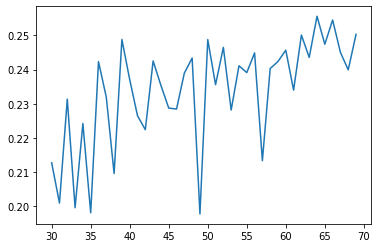

In [ ]:
plt.plot(nr_col,f1_ss) #before

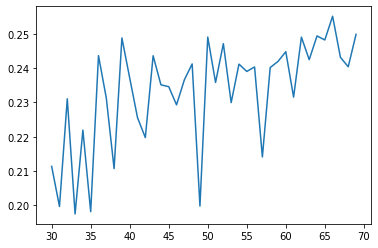

In [ ]:
plt.plot(nr_col,f1_ss)

##LETS KEEP IT 50... **BASELINE**

In [ ]:
train_df=train[['token','target']] #BECAUSE ITS BASELINE
test_df=test[['token','target']]


train_df=downsample(train_df,820000)
train_df.reset_index(inplace=True) #necessary after the down sample



train_tokens,test_tokens = vectorize_hash_token(train_df.token,test_df.token)

#here you do all the shit with the other features

X_train=pd.concat([train_tokens,train_df['target']],axis=1) #here you concat with all the shit
X_test=pd.concat([test_tokens,test_df['target']],axis=1)


#this is the last thing to do as you want your helper to have all teh features and make better helping predicitons
helper_train,helper_test=get_helper1(X_train,X_test)
X_train['helper1']=helper_train
X_test['helper1']=helper_test



KeyboardInterrupt: ignored

In [ ]:
y_train,y_test=make_cat_label(X_train.pop('target'),X_test.pop('target'))

In [ ]:
#instantiate the model
log_regression = LogisticRegression(penalty='l2')

#fit the model using the training data
log_regression.fit(X_train,y_train)

#use model to make predictions on test data
y_pred = log_regression.predict(X_test)


In [ ]:
f1 = f1_score(y_test,y_pred, average='weighted')
prec = precision_score(y_test,y_pred, average='weighted')
rec = recall_score(y_test,y_pred,average='weighted')
print(f"{f1=}")
print(f"{prec=}")
print(f'{rec=}')

##THE MODELL

In [ ]:
def categorical_features(df,cols,N_out_feature=12):
  cat_features=df[cols]
  # Apply the hashing trick to the categorical features
  hasher = FeatureHasher(n_features=N_out_feature, input_type='string')
  hashed_features = hasher.transform(cat_features.values.astype(str))
  hashed_features = pd.DataFrame(hashed_features.toarray(),columns=["cat_"+str(i) for i in range(0,N_out_feature)])
  return hashed_features



In [ ]:
train_df=train[train["distance_head"]!="_"].reset_index(drop=True)#like this reset_index(drop=True)
#train_df=downsample(train_df,620000)
train_df.reset_index(inplace=True) #necessary after the removing rows
test_df=test[test["distance_head"]!="_"].reset_index(drop=True)#like this reset_index(drop=True)


#get vectorized tokens
train_tokens,test_tokens = vectorize_hash_token(train_df.token,test_df.token)


#get numerical features
cols_num=['sent_id', 'token_id', 'distance_head']
train_num=numerical_features(train_df,cols_num)
test_num=numerical_features(test_df,cols_num)


#here you do all the shit with the more? features


#categorical features
cols_cat_features = ['POS', 'uni_POS', 'morph_type',
                     'dep_label', 'dep_rel', 'space', 'probbank']

train_cat=categorical_features(train_df,cols_cat_features)
test_cat=categorical_features(test_df,cols_cat_features)



X_train=pd.concat([train_tokens,train_cat,train_num,train_df['target']],axis=1) #here you concat with all the shit
X_test=pd.concat([test_tokens,test_cat,test_num,test_df['target']],axis=1)


#this is the last thing to do as you want your helper to have all teh features and make better helping predicitons
helper_train,helper_test=get_helper1(X_train,X_test)
X_train['helper1']=helper_train
X_test['helper1']=helper_test
y_train,y_test=make_cat_label(X_train.pop('target'),X_test.pop('target'))

y_pred=logistic_reg(X_train,X_test,y_train,y_test)
f1 = f1_score(y_test,y_pred, average='weighted')
prec = precision_score(y_test,y_pred, average='weighted')
rec = recall_score(y_test,y_pred,average='weighted')
print(f"{f1=}")
print(f"{prec=}")
print(f'{rec=}')

f1=0.7694308344358105
prec=0.7085515619625078
rec=0.8417550486706378


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#this is with no downsampling